# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ../python 

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


In [2]:
!pip3 -q install torch

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', error(104, 'Connection reset by peer'))': /simple/future/


In [3]:
from unityagents import UnityEnvironment
import numpy as np
from collections import namedtuple, deque

from ddpg_agent import Agent

from collections import deque
import matplotlib.pyplot as plt
import torch
%matplotlib inline

from workspace_utils import active_session

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [4]:
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
# Define DDPG

def ddpg(n_episodes=2000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    scores = []                        # list containing scores from each episode
    mov_avg = []
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations              # get the current state
        agent.reset()
        score = np.zeros(num_agents)
        for i in range(1000):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations      # get the next state
            rewards = env_info.rewards                      # get the reward          
            for state, action, reward, next_state in zip(states, actions, rewards, next_states):
                agent.step(state, action, reward, next_state)
            states = next_states
            score += rewards            
        scores_window.append(score.mean())       # save most recent score
        scores.append(score.mean())              # save most recent score
        mov_avg.append(np.mean(scores_window))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 20 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if mov_avg[-1]>=30.0 and i_episode >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\n'
                  .format(i_episode-100, np.mean(scores_window)))
            break
    return scores, mov_avg

In [8]:
with active_session():
    agent = Agent(state_size, action_size, seed=0)
    %time scores, mov_avg = ddpg(n_episodes=2000)

Episode 20	Average Score: 22.30
Episode 40	Average Score: 28.35
Episode 60	Average Score: 30.93
Episode 80	Average Score: 32.33
Episode 100	Average Score: 32.80

Environment solved in 0 episodes!	Average Score: 32.80

CPU times: user 5h 9min 33s, sys: 6min 9s, total: 5h 15min 42s
Wall time: 5h 22min 2s


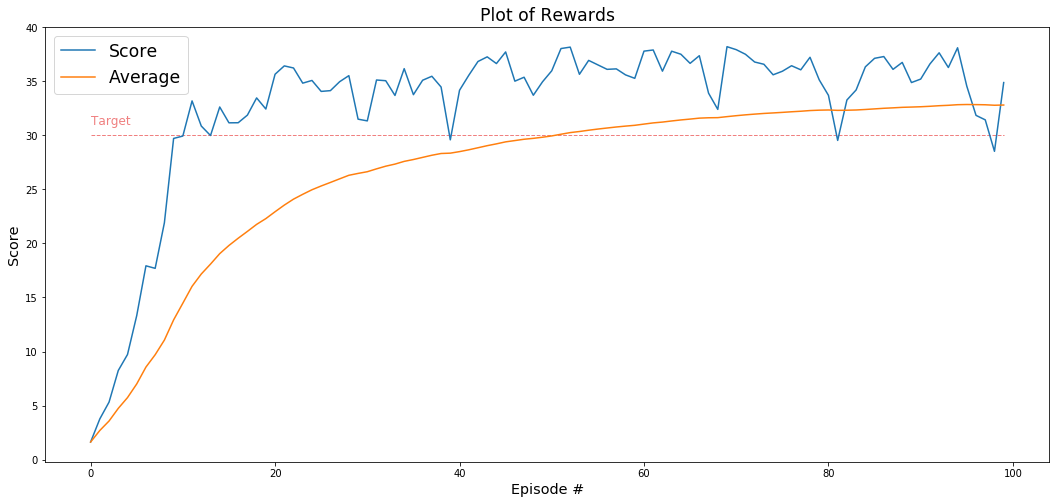

In [9]:
# Preprocess some variables
target_value = 30
target = [target_value] * len(scores) # Trace a line indicating the target value

# plot the scores
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax.set_title('Plot of Rewards', fontsize='xx-large')
ax.plot(target, linestyle='--', color='LightCoral', linewidth=1, zorder=0)
ax.plot(np.arange(len(scores)), scores, label='Score')
ax.plot(np.arange(len(mov_avg)), mov_avg, label='Average')
ax.set_ylabel('Score', fontsize='x-large')
ax.set_xlabel('Episode #', fontsize='x-large')
ax.text(0, target_value+1, 'Target', color='LightCoral', fontsize='large')
ax.legend(fontsize='xx-large', loc='upper left')
plt.show()    

In [10]:
## Save the model along with some training information
checkpoint = {
    'actor_dict': agent.actor_local.state_dict(),
    'critic_dict': agent.critic_local.state_dict(),
    'scores': scores,
    'mov_avg': mov_avg
    }
print('\nSaving model ...')
torch.save(checkpoint, 'checkpoint.pt')


Saving model ...


In [11]:
env.close()